In [3]:
# імпортували необхідні бібліотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


In [4]:
# завантажуємо данні
df = pd.read_csv("C:/Users/user/AnacondaProj/archive/car data.csv")

In [5]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [6]:
df.shape

(301, 9)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [8]:
# чисельна статистика
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [9]:
# перевіряємо чи є втрачені значення
df.isna().sum()


Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

### Data Preprocessing


In [10]:
# Створюємо нову колонку з віком машин

from datetime import datetime
currentYear = datetime.now().year

df['Age'] = currentYear - df['Year']
df.drop('Year',axis=1,inplace = True)
df.drop('Car_Name',axis=1,inplace = True)


In [11]:
df.columns

Index(['Selling_Price', 'Present_Price', 'Kms_Driven', 'Fuel_Type',
       'Seller_Type', 'Transmission', 'Owner', 'Age'],
      dtype='object')

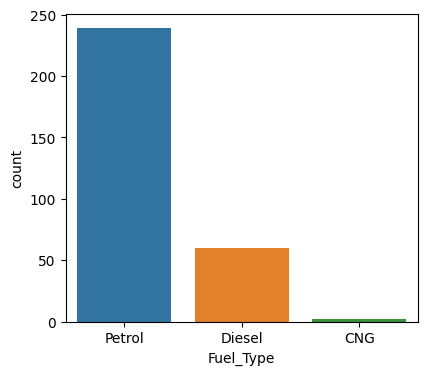

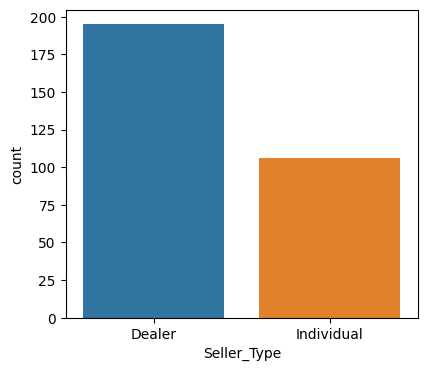

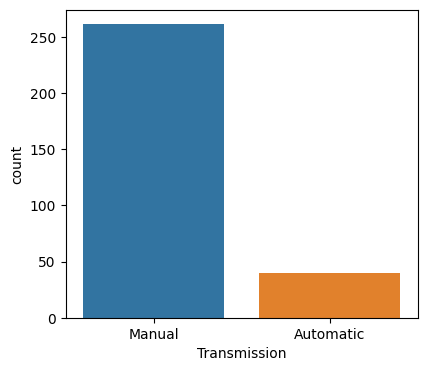

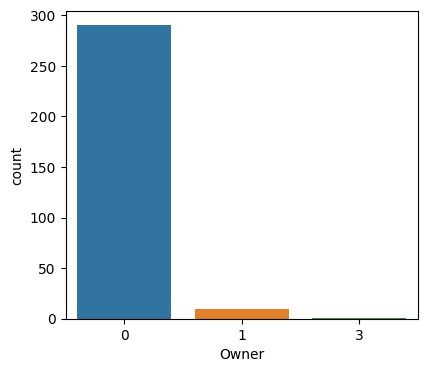

In [12]:
# EDA
import warnings
warnings.simplefilter(action='ignore')

cat_cols = ['Fuel_Type','Seller_Type','Transmission','Owner']

for i in range(len(cat_cols)):
    fig = plt.figure(figsize=[10,4])    
    plt.subplot(1,2,1)
    sns.countplot(x=cat_cols[i], data=df)

    
    plt.show()

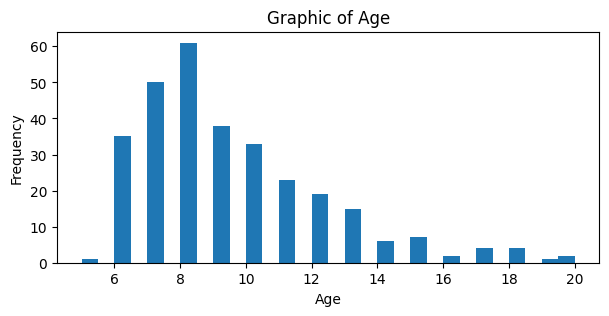

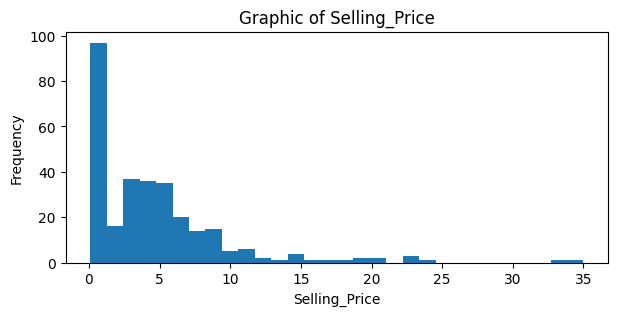

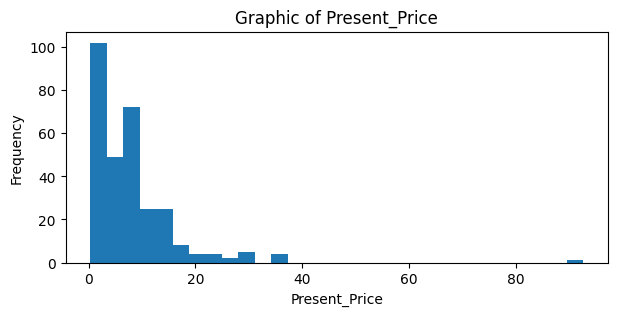

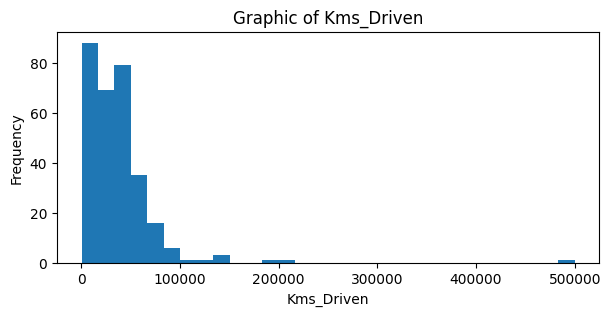

In [13]:
def plot_hist(variable):
    plt.figure(figsize=(7,3))
    plt.hist(df[variable], bins = 30)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title(f"Graphic of {variable}")
    plt.show()

numeric = ["Age", "Selling_Price", "Present_Price", "Kms_Driven"] 
for i in numeric:
    plot_hist(i)

In [14]:
# Створення dummies для категоріальних ознак
df1 = pd.get_dummies(data = df, drop_first=True)
df1.head()

,Selling_Price,Present_Price,Kms_Driven,Owner,Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,9,False,True,False,True
1,4.75,9.54,43000,0,10,True,False,False,True
2,7.25,9.85,6900,0,6,False,True,False,True
3,2.85,4.15,5200,0,12,False,True,False,True
4,4.60,6.87,42450,0,9,True,False,False,True


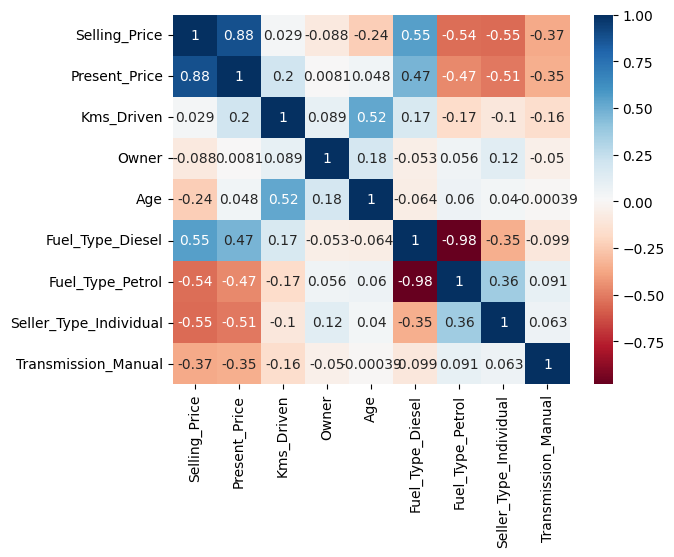

In [15]:
sns.heatmap(df1.corr(), annot=True, cmap="RdBu")
plt.show()

#### Бачимо що найбільша кореляція між Selling_Price та Present_Price

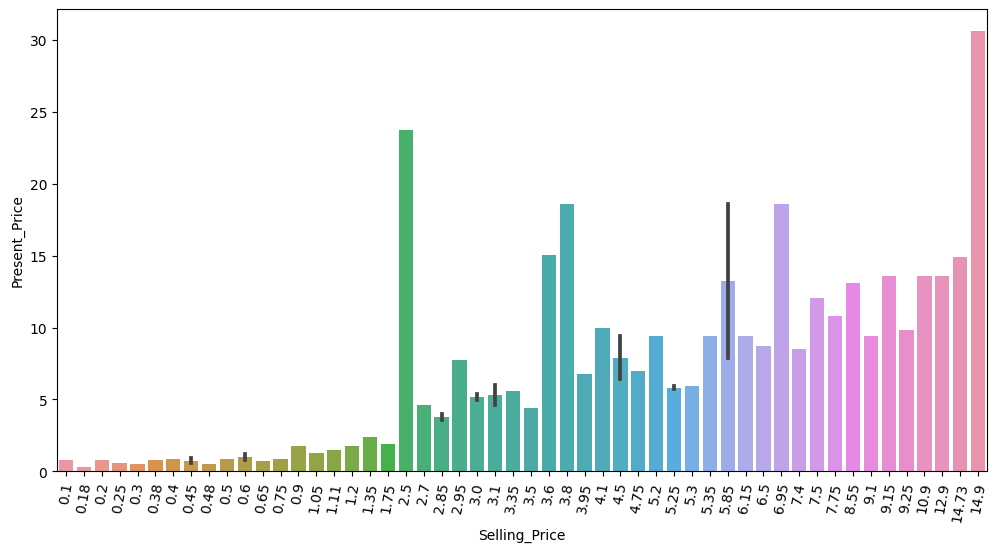

In [16]:
plt.figure(figsize=(12,6))
sns.barplot(data = df1[::5], x = "Selling_Price", y = "Present_Price")
plt.xticks(rotation=80)
plt.show() 

#### Бачимо що є лінійне зростання

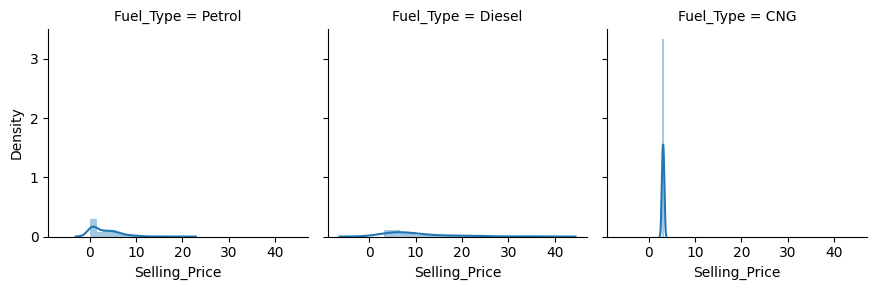

In [17]:
fig = sns.FacetGrid(df, col = "Fuel_Type")
fig.map(sns.distplot, "Selling_Price")
plt.show()

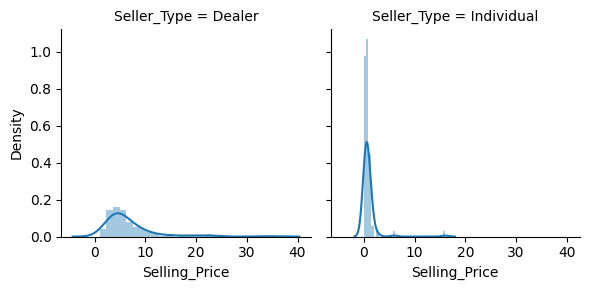

In [18]:
fig = sns.FacetGrid(df, col = "Seller_Type")
fig.map(sns.distplot, "Selling_Price")
plt.show()

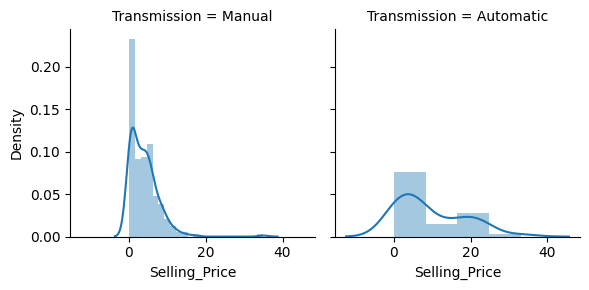

In [19]:
fig = sns.FacetGrid(df, col = "Transmission")
fig.map(sns.distplot, "Selling_Price")
plt.show()

In [20]:
# Знаходимо індекси витоків
def detect_outlier(df_, features):
    outlier_indices = []
    for i in features:
        q1 = np.percentile(df_[i], 25)
        q3 = np.percentile(df_[i], 75)
        iqr = q3 - q1
        outlier_step = iqr * 1.5
        outlier_list = df_[(df_[i] < q1 - outlier_step) | (df_[i] > q3 + outlier_step)].index
        outlier_indices.extend(outlier_list)

    return(outlier_indices)

outliers = detect_outlier(df1, ["Selling_Price", "Present_Price", "Kms_Driven"])
outliers

[50,
 51,
 52,
 53,
 59,
 62,
 63,
 64,
 66,
 69,
 79,
 80,
 82,
 86,
 93,
 96,
 97,
 50,
 51,
 53,
 59,
 62,
 63,
 64,
 66,
 79,
 82,
 85,
 86,
 93,
 96,
 37,
 50,
 53,
 77,
 84,
 85,
 179,
 196]

In [21]:
# видаляємо витоки з даних
df1 = df1.drop(outliers, axis=0).reset_index(drop=True) 

In [22]:
# Відокремлюємо цільову зміну від її ознак
y = df1['Selling_Price']
X = df1.drop('Selling_Price',axis=1)

In [23]:
# Рщзподіляємо дані для тренування і тестування, де 80 відсотків тренувальних даних
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (222, 8)
X_test shape:  (56, 8)
y_train shape:  (222,)
y_test shape:  (56,)


### Маштабуємо дату за допомогою Standard Scaler

In [25]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
R2_train = []
R2_test = []
MSE_train = []
MSE_test = []

def car_pred_model(model):
    # тренуємо модель
    model.fit(X_train_scaled,y_train)
            
    y_pred_train = model.predict(X_train_scaled)
    
    # R2 для тренувального набору
    R2_train_model = r2_score(y_train,y_pred_train)
    R2_train.append(round(R2_train_model,2))
    
    y_pred_test = model.predict(X_test_scaled)
    
    # R2 для тестувального набору
    R2_test_model = r2_score(y_test,y_pred_test)
    R2_test.append(round(R2_test_model,2))
    
    # MSE для тренувального набору
    MSE_train_model = mean_squared_error(y_train,y_pred_train)
    MSE_train.append(round(MSE_train_model,2))
    
    # MSE для тестувального набору
    MSE_test_model = mean_squared_error(y_test,y_pred_test)
    MSE_test.append(round(MSE_test_model,2))
    
    print("Train R2-score :",round(R2_train_model,2))
    print("Test R2-score :",round(R2_test_model,2))
    print("Train MSE-score :",round(MSE_train_model,2))
    print("Test MSE-score :",round(MSE_test_model,2))
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x = y_test, y = y_pred_test, label='Train', alpha=0.5)
    plt.scatter(y_train, y_pred_train, label='Train', alpha=0.5)
    plt.xlabel('y')
    plt.ylabel('y_pred')
    
    plt.show()
    
    plt.figure(figsize=(10, 6))

    plt.scatter(range(len(y_train)), y_train - y_pred_train, label='Train Residuals', alpha=0.5)
    plt.scatter(range(len(y_test)), y_test - y_pred_test, label='Test Residuals', alpha=0.5)

    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Спостереження')
    plt.ylabel('Різниця')
    plt.legend()
    plt.title('Графік різниці')
    plt.show()
    

    

Train R2-score : 0.88
Test R2-score : 0.79
Train MSE-score : 1.09
Test MSE-score : 2.24


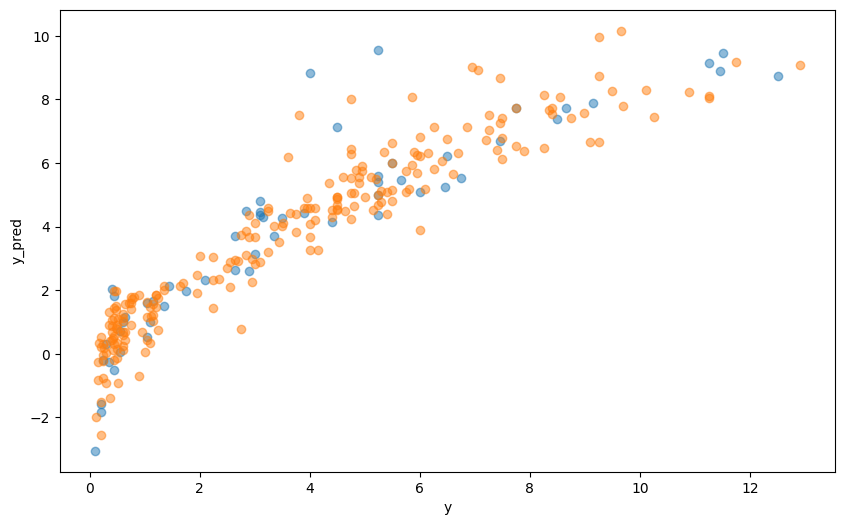

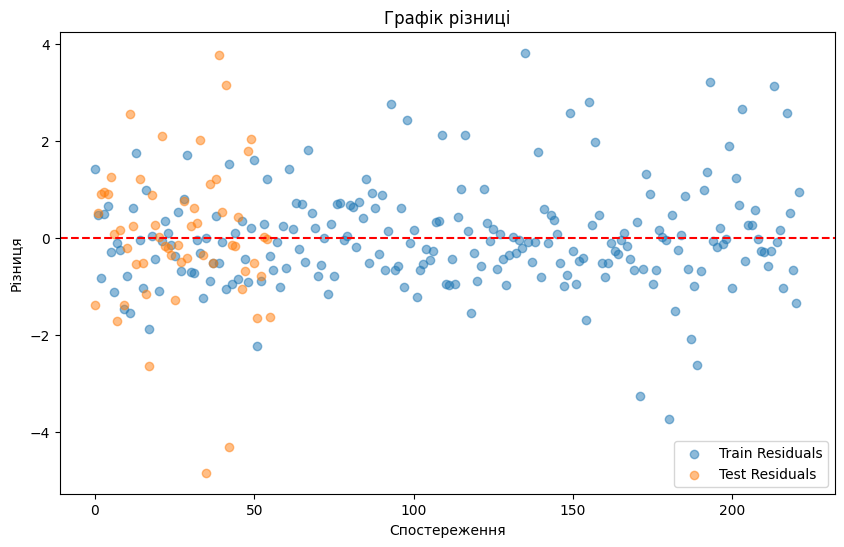

In [39]:
lr = LinearRegression()
car_pred_model(lr)

Train R2-score : 0.88
Test R2-score : 0.79
Train MSE-score : 1.09
Test MSE-score : 2.24


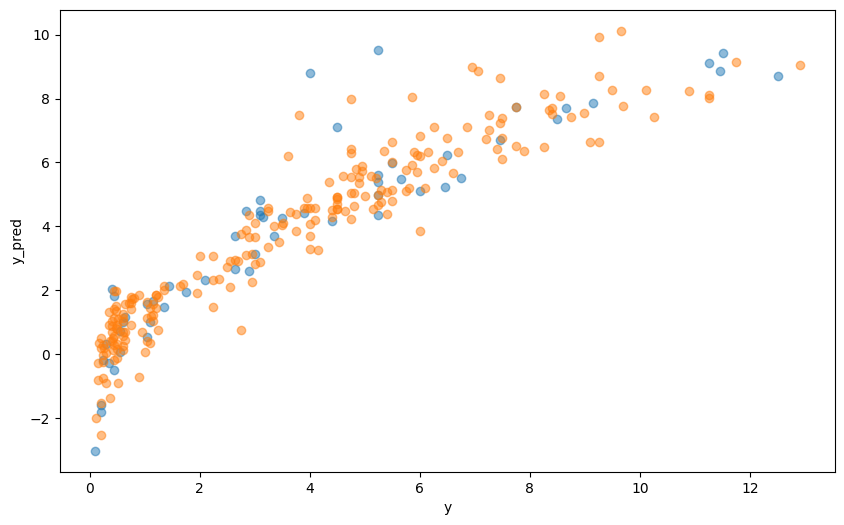

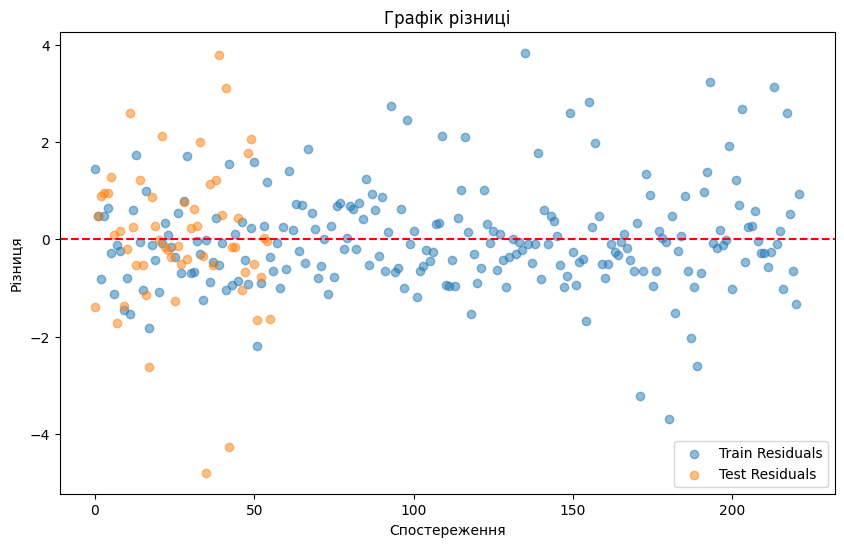

In [40]:
rg = Ridge()

car_pred_model(rg)

Train R2-score : 0.99
Test R2-score : 0.92
Train MSE-score : 0.07
Test MSE-score : 0.87


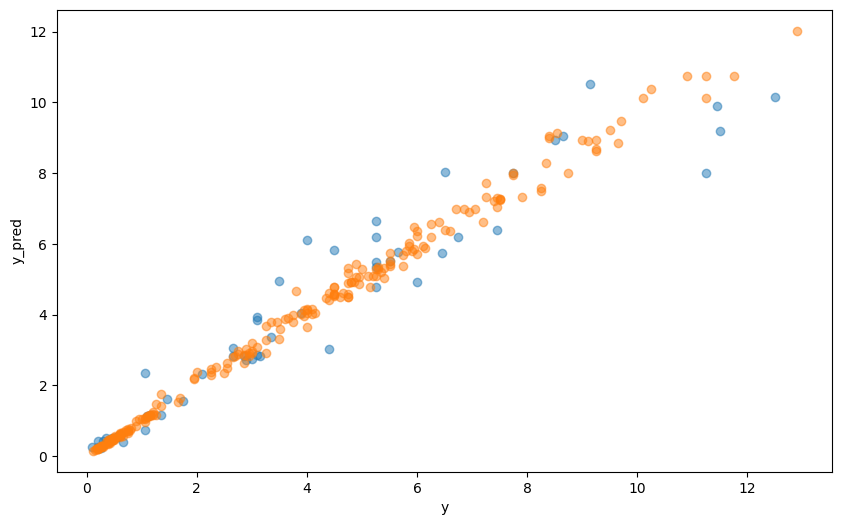

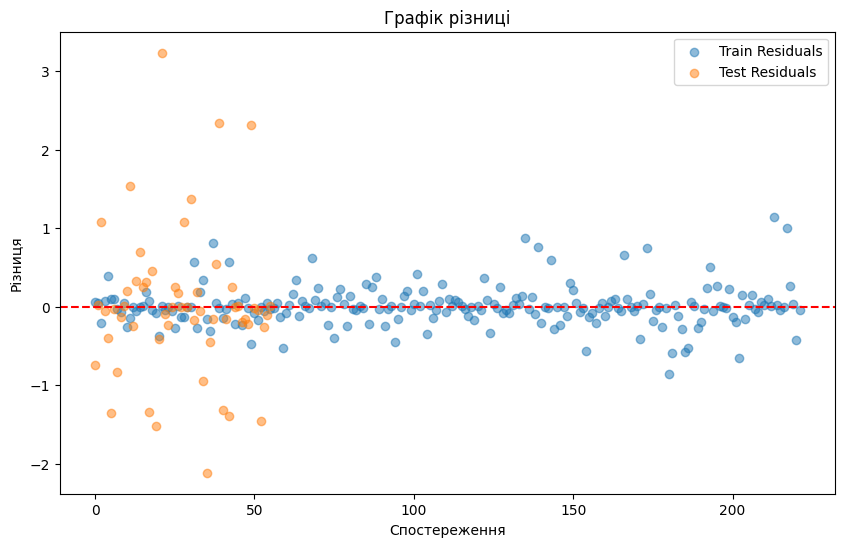

In [41]:
rf = RandomForestRegressor()

car_pred_model(rf)

,Model,R Squared(Train),R Squared(Test),MSE(Train),MSE(Test)
0,Linear Regression,0.88,0.79,1.09,2.24
1,Ridge,0.88,0.79,1.09,2.24
2,RandomForestRegressor,0.99,0.92,0.07,0.87


Text(0.5, 1.0, 'MSE on Test Data')

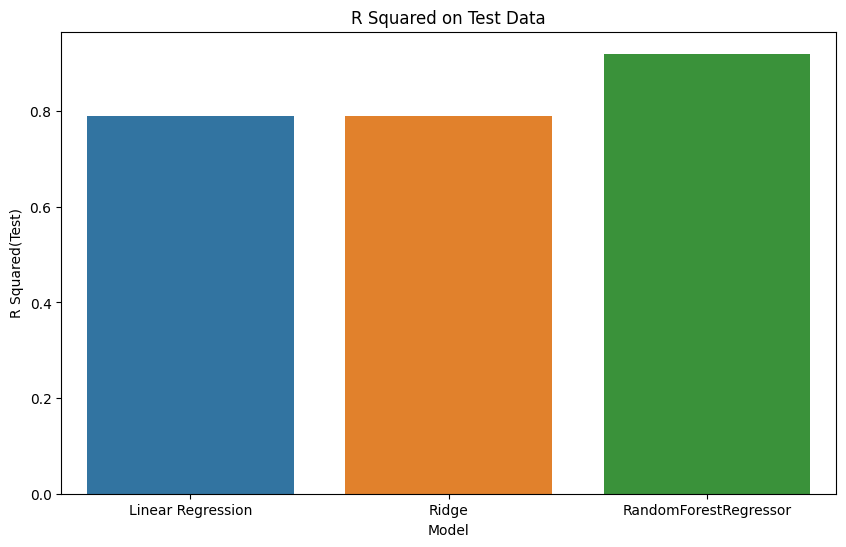

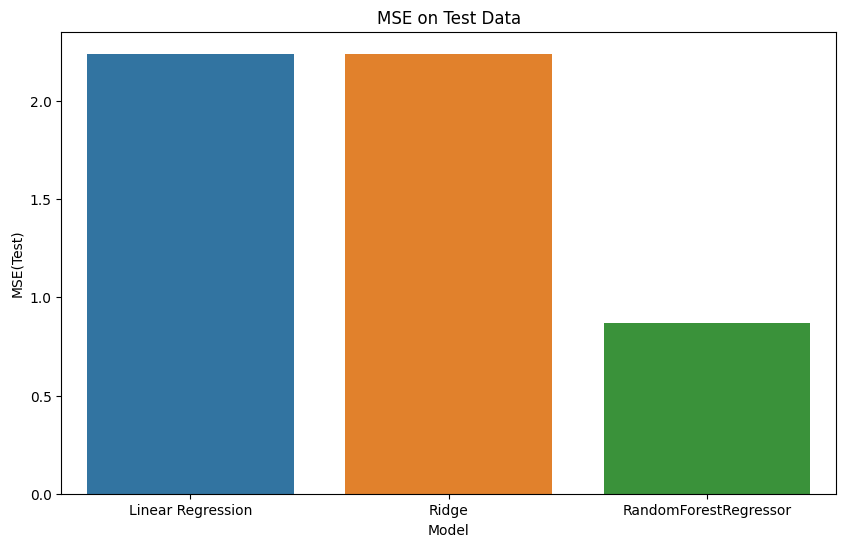

In [43]:
Technique = ["Linear Regression","Ridge", "RandomForestRegressor"]
results=pd.DataFrame({'Model': Technique,'R Squared(Train)': R2_train ,'R Squared(Test)': R2_test, 
                      'MSE(Train)': MSE_train ,'MSE(Test)': MSE_test })
display(results)

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R Squared(Test)', data=results)
plt.title('R Squared on Test Data')

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MSE(Test)', data=results)
plt.title('MSE on Test Data')
    

## Висновки

В цьому завданні я навчилась використовувати різні регресійні моделі. Я обрала набір даних про ціни машин. Обробіть дані, видаливши будь-які відсутні значення та нормалізувавши дані та видоливши витоки. Я поділила вибірку на train та test в пропорції 80/20, для цього ми використали метод sklearn train_test_split() та з random_state щоб наші предикти були постійно однакові для однакових даних. 

Наступним кроком було тренування моделей, використовуючи об'єкт типу LinearRegression, Ridge та RandomForestRegressor. 

На останньому кроці я перевіряла моделі. Для цього я використовувала  розрахунок Mean Square Error та R2 score. Після обчислення, ми виявили, що наші дані найкраще передбачаються з RandomForestRegressor, бо MSE_test= 0.80 та R2_test = 0.93.
